# Gmail Smart Compose Case Study

# 1. Business problem

Gmail Smart Compose is a feature introduced in the popular Google email service back in 2018, which helps to save time on repetitive writing by suggesting relevant contextual phrases. We engage in a lot of text-based communication on a daily basis. Most of the web and mobile apps today come with great features to improve productivity. For instance, WhatsApp offers a predictive text and Google search auto completes our queries with trending searches as you type in Here the task is to build model which can predict the next words based up on input words. So here input is sequence and output also a sequence can output can a single word as well. We are going to use sequence2 sequence models, Encoder-Decoder Architecture, Recurrent neural networks, RNN, LSTM and GRUs

# 2. Dataset analysis

The biggest public email dataset available is the Enron email dataset, which contains approximately 500,000 emails generated by employees of the Enron Corporation. It was obtained by the Federal Energy Regulatory Commission during its investigation of Enron’s collapse. Despite its relatively big size the usage of this dataset has faced different challenges. data set contain only two columns, the first column is the file’s name, and the second one is the message.

Data Source: - https://www.kaggle.com/datasets/wcukierski/enron-email-dataset?resource=download

Performance metric: - For this problem I will be using perplexity and BLEU (Bilingual Evaluation Understudy)BLEU (Bilingual Evaluation Understudy) as performance metric.

# 3. Performance metric

For this problem I will be using perplexity and BLEU (Bilingual Evaluation Understudy)BLEU (Bilingual Evaluation Understudy) as performance metric. Perplexity :- • Perplexity is a metric used to judge how good a language model is.

• We can define perplexity as the inverse probability of the test set, normalised by the number of words:

• Since we’re taking the inverse probability, hence lower perplexity indicates a better model.

• And we can interpret perplexity as the weighted branching factor. suppose for a model If we have a perplexity of 100, it means that whenever the model is trying to guess the next word it is as confused as if it had to pick between 100 words. Which is not good for our model.

More about this metric:- https://towardsdatascience.com/perplexity-in-language-models87a196019a94

BLEU:- The Bilingual Evaluation Understudy Score, or BLEU for short, is a metric for evaluating a generated sentence to a reference sentence. A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0. The score was developed for evaluating the predictions made by automatic machine translation systems. It is not perfect, but does offer 5 compelling benefits:

• It is quick and inexpensive to calculate.

• It is easy to understand.

• It is language independent.

• It correlates highly with human evaluation.

• It has been widely adopted.

More about this metric:- https://towardsdatascience.com/perplexity-in-language-models87a196019a94

# Importing the packages

In [4]:
import numpy as np
from tqdm import tqdm
import email
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import re
import nltk
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

# Encoder Decoder Models

# Data preparation:-

In [3]:
# loading the final email dataset after all the cleaning is done
Final_Data=pickle.load(open("../input/final-preprocessed-data-case-study2/emails_df_final_2606.pkl","rb"))

# Shape of final dataset

In [6]:
Final_Data.shape

(210450, 3)

In [7]:
Final_Data.head()

,mail_content,mail_content_len,clean_mail_content
1,Traveling to have a business meeting takes the...,786,traveling to have a business meeting takes the...
3,"Randy,\n\n Can you send me a schedule of the s...",187,"randy, can you send me a schedule of the salar..."
5,"Greg,\n\n How about either next Tuesday or Thu...",59,"greg, how about either next tuesday or thursda..."
6,Please cc the following distribution list with...,242,please cc the following distribution list with...
8,1. login: pallen pw: ke9davis\n\n I don't thi...,224,. login pallen pw ke davis i don't think these...


# Dropping the mail_content and mail_content_len colums from dataset

In [8]:
Final_Data.drop(["mail_content","mail_content_len"],axis=1,inplace=True)

In [9]:
#final dataset few records
Final_Data.head()

,clean_mail_content
1,traveling to have a business meeting takes the...
3,"randy, can you send me a schedule of the salar..."
5,"greg, how about either next tuesday or thursda..."
6,please cc the following distribution list with...
8,. login pallen pw ke davis i don't think these...


In [10]:
Final_Data.shape

(210450, 1)

# Calculating the number of words in each emails

In [11]:
Final_Data['clean_mail_content_len'] = Final_Data['clean_mail_content'].apply(lambda x:len(nltk.word_tokenize(x)))

# Removing all the rows which have length more than 20

In [12]:
Final_Data=Final_Data[Final_Data["clean_mail_content_len"]<=20]

In [13]:
pickle.dump(Final_Data,open("Final_Data.pkl","wb"))#pickled the data after removeing sentence having length more than 20 ang got 19069 records

In [14]:
Final_Data=pickle.load(open("../input/final-preprocessed-data-case-study2/Final_Data.pkl","rb"))

In [15]:
Final_Data.head()

,clean_mail_content,clean_mail_content_len
5,"greg, how about either next tuesday or thursda...",11
9,,0
29,nymex expiration is during this time frame. pl...,11
36,"greg, happy b day. email me your phone and i w...",17
62,"ina, i scheduled a meeting with jean mrha tomo...",11


# Final dataset after removeing the email with length more than 20

In [16]:
Final_Data.shape

(19069, 2)

# Data preparation

In [17]:
output=[]
for i in tqdm(Final_Data["clean_mail_content"].values):
    token_list=i.split()
    for j in range(len(token_list)-1):
        data = []
        x_ngram =' '.join(token_list[:j+1]) 
        y_ngram =' '.join(token_list[j+1:])
        data.append(x_ngram)
        data.append(y_ngram)
        output.append(data)
Final_df = pd.DataFrame(output, columns=['input','output'])

100%|██████████| 19069/19069 [00:00<00:00, 34338.76it/s]


In [18]:
Final_df.head()

,input,output
0,"greg,",how about either next tuesday or thursday? phi...
1,"greg, how",about either next tuesday or thursday? phillip
2,"greg, how about",either next tuesday or thursday? phillip
3,"greg, how about either",next tuesday or thursday? phillip
4,"greg, how about either next",tuesday or thursday? phillip


In [19]:
Final_df.shape

(210792, 2)

# Calculaing the length of of both input and output columns

In [20]:
%%time
Final_df['input_len'] = Final_df['input'].apply(lambda x:len(nltk.word_tokenize(x)))
Final_df['output_len'] = Final_df['output'].apply(lambda x:len(nltk.word_tokenize(x)))

CPU times: user 1min 7s, sys: 22.7 ms, total: 1min 7s
Wall time: 1min 7s


In [21]:
Final_df.shape

(210792, 4)

In [22]:
Final_df.head()

,input,output,input_len,output_len
0,"greg,",how about either next tuesday or thursday? phi...,2,9
1,"greg, how",about either next tuesday or thursday? phillip,3,8
2,"greg, how about",either next tuesday or thursday? phillip,4,7
3,"greg, how about either",next tuesday or thursday? phillip,5,6
4,"greg, how about either next",tuesday or thursday? phillip,6,5


In [23]:
pickle.dump(Final_df,open("Final_df_enc_dec2606_final.pkl","wb")) # pickled the final encoder decoder data set with 210792 records

In [24]:
Final_df=pickle.load(open("../input/final-preprocessed-data-case-study2/Final_df_enc_dec2606_final.pkl","rb"))

In [25]:
Final_df.shape

(210792, 4)

In [26]:
Final_df.head()

,input,output,input_len,output_len
0,"greg,",how about either next tuesday or thursday? phi...,2,9
1,"greg, how",about either next tuesday or thursday? phillip,3,8
2,"greg, how about",either next tuesday or thursday? phillip,4,7
3,"greg, how about either",next tuesday or thursday? phillip,5,6
4,"greg, how about either next",tuesday or thursday? phillip,6,5


# max length of input is 20

In [27]:
max(Final_df["input_len"])

20

# max length of output is 19

In [28]:
max(Final_df["output_len"])

19

# Preparing the data for train dataset

In [29]:
# Add start and end tokens to target sequences in oder to use teacher forcing traning method
Final_df["Encoder_input"] = Final_df.input.apply(lambda x : '<start> '+ x + ' <end>')
Final_df["Decoder_input"] = Final_df.output.apply(lambda x : '<start> '+ x)
Final_df["Decoder_output"] = Final_df.output.apply(lambda x : x + ' <end>')

In [30]:
Final_df.head()

,input,output,input_len,output_len,Encoder_input,Decoder_input,Decoder_output
0,"greg,",how about either next tuesday or thursday? phi...,2,9,"<start> greg, <end>",<start> how about either next tuesday or thurs...,how about either next tuesday or thursday? phi...
1,"greg, how",about either next tuesday or thursday? phillip,3,8,"<start> greg, how <end>",<start> about either next tuesday or thursday?...,about either next tuesday or thursday? phillip...
2,"greg, how about",either next tuesday or thursday? phillip,4,7,"<start> greg, how about <end>",<start> either next tuesday or thursday? phillip,either next tuesday or thursday? phillip <end>
3,"greg, how about either",next tuesday or thursday? phillip,5,6,"<start> greg, how about either <end>",<start> next tuesday or thursday? phillip,next tuesday or thursday? phillip <end>
4,"greg, how about either next",tuesday or thursday? phillip,6,5,"<start> greg, how about either next <end>",<start> tuesday or thursday? phillip,tuesday or thursday? phillip <end>


In [31]:
Final_df.shape

(210792, 7)

# Performing the train test split with 15 % data used for testing

In [32]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(Final_df,test_size=0.15,random_state=12)

# Final test and train dataset size

In [33]:
print("train dataset size {}".format(train.shape))
print("test dataset size {}".format(test.shape))

train dataset size (179173, 7)
test dataset size (31619, 7)


In [34]:
train.head()

,input,output,input_len,output_len,Encoder_input,Decoder_input,Decoder_output
182665,your message to ruth reile e mail subject fina...,was read on pm.,13,5,<start> your message to ruth reile e mail subj...,<start> was read on pm.,was read on pm. <end>
40288,"bob, i know that you made this work",!! this recovery plan is exceptional. regards ...,9,10,"<start> bob, i know that you made this work <end>",<start> !! this recovery plan is exceptional. ...,!! this recovery plan is exceptional. regards ...
40990,"kay, please ensure that her expense statements",are signed by me. regards delainey,8,7,"<start> kay, please ensure that her expense st...",<start> are signed by me. regards delainey,are signed by me. regards delainey <end>
95053,lou just called,to see if you are up for dinner downtown tonig...,3,15,<start> lou just called <end>,<start> to see if you are up for dinner downto...,to see if you are up for dinner downtown tonig...
44418,new plan. staying in calgary. want to,go to earl's? call me!,9,8,<start> new plan. staying in calgary. want to ...,<start> go to earl's? call me!,go to earl's? call me! <end>


In [35]:
test.head()

,input,output,input_len,output_len,Encoder_input,Decoder_input,Decoder_output
36633,"jeff, just looking at",teeing my a schedule. any feedback from either...,5,12,"<start> jeff, just looking at <end>",<start> teeing my a schedule. any feedback fro...,teeing my a schedule. any feedback from either...
147460,original message,"from mann, kay sent wednesday, july , am to pe...",2,17,<start> original message <end>,"<start> from mann, kay sent wednesday, july , ...","from mann, kay sent wednesday, july , am to pe..."
58553,please increase consumer's delivery from to ef...,. call me on if you have any questions. thanks.,8,12,<start> please increase consumer's delivery fr...,<start> . call me on if you have any questions...,. call me on if you have any questions. thanks...
192757,the conference call with peruvian counsel,will be at am. we can call them from your office.,6,13,<start> the conference call with peruvian coun...,<start> will be at am. we can call them from y...,will be at am. we can call them from your offi...
64200,we will launch as soon as we,get the mailout to our customers. mike,7,8,<start> we will launch as soon as we <end>,<start> get the mailout to our customers. mike,get the mailout to our customers. mike <end>


# Created function to tokenize the train and test data

In [36]:
def tokenization(x_train,x_test):
    '''this functon will take input both train and test data and tokenize them'''
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(x_train)
    x_train = tokenizer.texts_to_sequences(x_train)
    x_test = tokenizer.texts_to_sequences(x_test)
    
    x_train = pad_sequences(x_train, padding='post')
    x_test = pad_sequences(x_test, padding='post')
    return tokenizer,x_train,x_test

# Calling the tokenization function for both train and test dataset

In [37]:
Enc_Tokenizer,X_train_Encoder_input,X_test_Encoder_input=tokenization(train["Encoder_input"],test["Encoder_input"])
Dec_Tokenizer,X_train_Decoder_input,X_test_Decoder_input=tokenization(train["Decoder_input"],test["Decoder_input"])
Dec_Tokenizer_target,X_train_Decoder_output,X_test_Decoder_output=tokenization(train["Decoder_output"],test["Decoder_output"])

# Calculating the vocab size for both input(x) and output(y)

In [38]:
input_vocab=len(Enc_Tokenizer.word_index)+1
output_vocab=len(Dec_Tokenizer_target.word_index)+1
print("input vocab length {}".format(input_vocab))
print("output vocab length {}".format(output_vocab))


input vocab length 19419
output vocab length 20955


In [39]:
print("train data Encoder input length {}".format(X_train_Encoder_input.shape[1]))
print("train data Deccoder input length {}".format(X_train_Decoder_input.shape[1]))
print("train data Deccoder output length {}".format(X_train_Decoder_output.shape[1]))

train data Encoder input length 21
train data Deccoder input length 20
train data Deccoder output length 20


In [40]:
print("test data Encoder input length {}".format(X_test_Encoder_input.shape[1]))
print("test data Deccoder input length {}".format(X_test_Decoder_input.shape[1]))
print("test data Deccoder output length {}".format(X_test_Decoder_output.shape[1]))

test data Encoder input length 21
test data Deccoder input length 20
test data Deccoder output length 20


# Defined the function to calculate the perplexity on train and test dataset

In [41]:
def perplexity(y_true, y_pred):
    """
    this function will calculate perplexity metric by calculates the cross entropy loss and takes its exponent for train and test dataset
    """
    return keras.backend.exp(keras.backend.mean(keras.backend.sparse_categorical_crossentropy(y_true, y_pred)))

In [43]:
# defining some vairable like embedding size , number of gru or lstm units batch size and epochs we are going to run to train the model
embedding_dim=100    
latent_dim= 100      
batch_size=512      
epochs = 30

# Model-1 Forward only GRU Encoder Decoder Model

In [44]:
# forward only GRU Encoder layer
encoder_in_layer = tf.keras.layers.Input(shape=(X_train_Encoder_input.shape[1],))

encoder_embedding = tf.keras.layers.Embedding(input_dim=input_vocab, output_dim=embedding_dim)

encoder_gru = tf.keras.layers.GRU(units=latent_dim, return_sequences=True, return_state=True)

# Discard the encoder output and use hidden states (h)
encoder_out, fstate_h= encoder_gru(encoder_embedding(encoder_in_layer))

# GRU Decoder layer
decoder_in_layer = tf.keras.layers.Input(shape=(None,))

decoder_embedding = tf.keras.layers.Embedding(input_dim=output_vocab, output_dim=embedding_dim)

decoder_gru = tf.keras.layers.GRU(units=latent_dim, return_sequences=True, return_state=True)

# Discard internal states in training, keep only the output sequence
decoder_gru_out, _ = decoder_gru(decoder_embedding(decoder_in_layer), initial_state=fstate_h)

decoder_dense = tf.keras.layers.Dense(output_vocab, activation="softmax")

decoder_out_layer = decoder_dense(decoder_gru_out)

# Define the model that uses the Encoder and the Decoder
model1 = tf.keras.models.Model([encoder_in_layer, decoder_in_layer], decoder_out_layer)

model1.compile(optimizer=Adam(learning_rate=0.01), loss="sparse_categorical_crossentropy", metrics=[perplexity])

model1.summary()

2022-06-26 10:04:49.207302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 10:04:49.316186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 10:04:49.316978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 10:04:49.318111: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 21, 100)      1941900     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    2095500     input_2[0][0]                    
______________________________________________________________________________________________

# Simple Forward only GRU Model Architecture

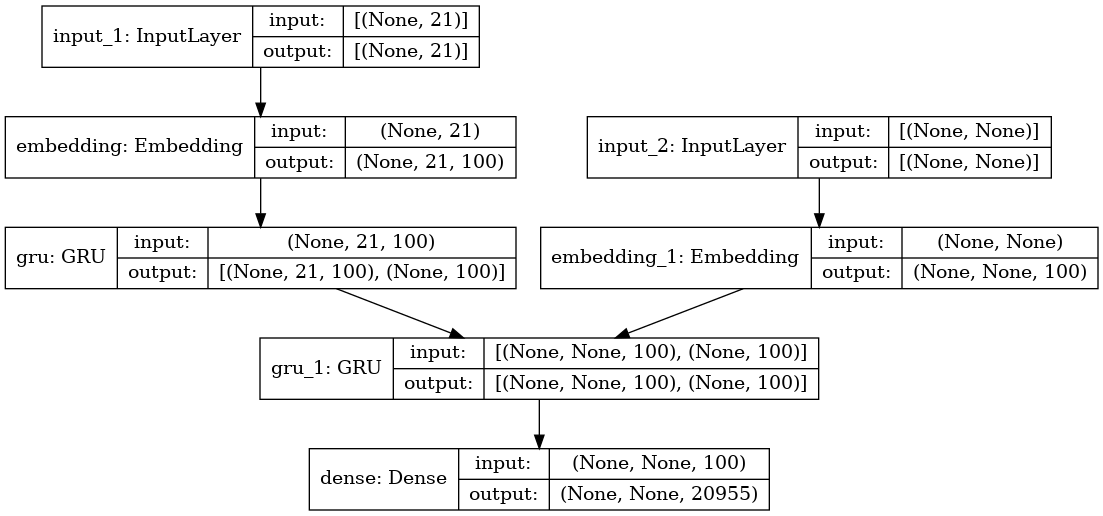

In [45]:
img_file = './GRU_model_arch.png'

tf.keras.utils.plot_model(model1, to_file=img_file, show_shapes=True, show_layer_names=True)

# Fitting the data to model(training)

In [46]:
history = model1.fit([X_train_Encoder_input, X_train_Decoder_input], X_train_Decoder_output,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=([X_test_Encoder_input,X_test_Decoder_input],X_test_Decoder_output))

2022-06-26 10:04:56.935613: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-06-26 10:05:00.243031: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


350/350 [==============================] - 36s 90ms/step - loss: 2.6658 - perplexity: 211.6803 - val_loss: 2.0317 - val_perplexity: 7.6383
Epoch 2/30
350/350 [==============================] - 31s 88ms/step - loss: 1.6430 - perplexity: 5.2681 - val_loss: 1.3547 - val_perplexity: 3.8780
Epoch 3/30
350/350 [==============================] - 31s 88ms/step - loss: 1.1630 - perplexity: 3.2074 - val_loss: 1.1010 - val_perplexity: 3.0089
Epoch 4/30
350/350 [==============================] - 31s 88ms/step - loss: 0.9705 - perplexity: 2.6406 - val_loss: 0.9902 - val_perplexity: 2.6929
Epoch 5/30
350/350 [==============================] - 31s 88ms/step - loss: 0.8726 - perplexity: 2.3938 - val_loss: 0.9269 - val_perplexity: 2.5277
Epoch 6/30
350/350 [==============================] - 31s 88ms/step - loss: 0.8115 - perplexity: 2.2518 - val_loss: 0.8861 - val_perplexity: 2.4269
Epoch 7/30
350/350 [==============================] - 31s 88ms/step - loss: 0.7688 - perplexity: 2.1578 - val_loss: 0.859

In [47]:
from keras.models import save_model
model1.save_weights('Gru_Model.hdf5')

In [134]:
#Load weights
model1.load_weights('./Gru_Model.hdf5')

# Evaluating the model on test data

In [49]:
perplexity_scores = model1.evaluate([X_test_Encoder_input, X_test_Decoder_input], X_test_Decoder_output)
print("perplexity of Forward only GRU Based encoder decoder model is: {}".format(perplexity_scores))

989/989 [==============================] - 6s 7ms/step - loss: 0.7378 - perplexity: 2.1019
perplexity of Forward only GRU Based encoder decoder model is: [0.7378235459327698, 2.1018543243408203]


# Plotting the graph for train and test loss and perplexity values

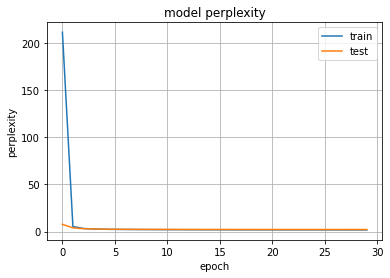

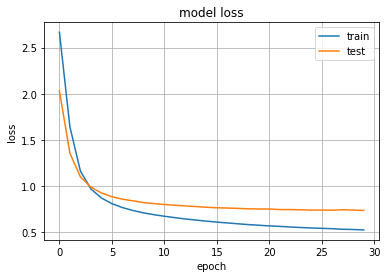

In [50]:
import matplotlib.pyplot as plt
# perplexity for Simple forward only GRU Encoder decoder model
plt.plot(history.history['perplexity'])
plt.plot(history.history['val_perplexity'])
plt.title('model perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid()
plt.show()
# Loss for Simple forward only GRU Encoder decoder model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid()
plt.show()

# Creating the inference for model1 for final prediction

In [51]:
 # Inference Encoder layers
#https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
encoder_model = keras.models.Model(encoder_in_layer, fstate_h)

# Inference Decoder layers
state_input_h = keras.layers.Input(shape=(latent_dim,))
decoder_out, decoder_h = decoder_gru(decoder_embedding(decoder_in_layer), initial_state=state_input_h)
decoder_out = decoder_dense(decoder_out)
decoder_model = keras.models.Model(inputs=[decoder_in_layer, state_input_h], 
                  outputs=[decoder_out, decoder_h])

# Encoder model inference

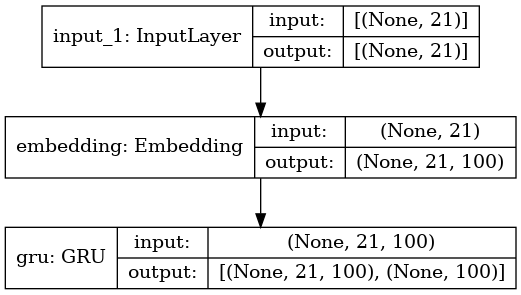

In [52]:
img_file = './Encoder_inference_GRU_model_arch.png'

tf.keras.utils.plot_model(encoder_model, to_file=img_file, show_shapes=True, show_layer_names=True)

# Decoder model inference

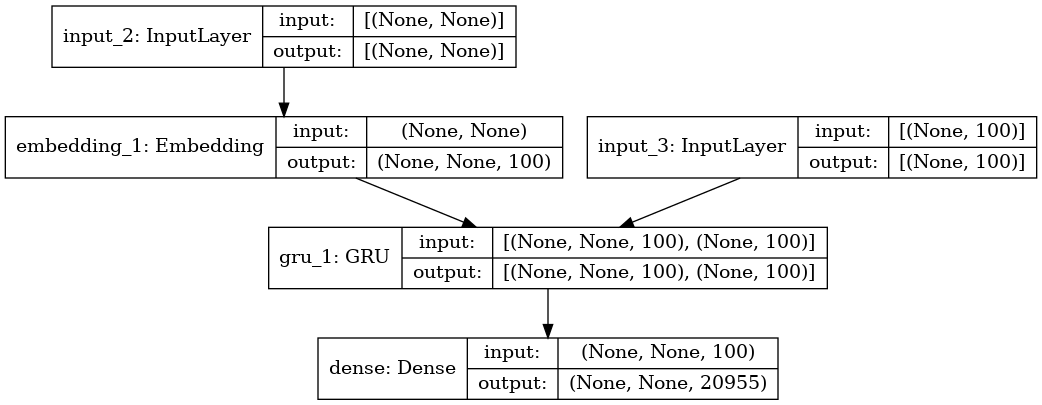

In [53]:
img_file = './Deocder_inference_GRU_model_arch.png'

tf.keras.utils.plot_model(decoder_model, to_file=img_file, show_shapes=True, show_layer_names=True)

# Creating dictionay of output vocab 

In [54]:
# Creating the dictiionary with output vocab words
target_token_index=Dec_Tokenizer_target.word_index
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

# Final pipeline for prediction

In [55]:
def decode_sequence(input_seq):
    '''this function will predict the next words sequences given the input sequences'''
    if input_seq.split(' ')[0] != '<start>' and input_seq.split(' ')[-1] != '<end>':
        input_seq = '<start>'+ ' ' + input_seq + ' ' + '<end>'
    
    input_seq = Enc_Tokenizer.texts_to_sequences([str(input_seq)])
    input_seq = pad_sequences(input_seq, padding="post",maxlen= 21)
    
     # Encode the input as state vectors.
    state = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = Dec_Tokenizer.word_index['<start>']
    
    # Encode the input as state vectors.
    curr_word = "<start>"
    decoded_sentence = ''

    i = 0
    while curr_word != "<end>" and i < (20 - 1):
        output_tokens, h = decoder_model.predict([target_seq, state])

        curr_token = np.argmax(output_tokens[0, 0])

        if (curr_token == 0):
            break;

        curr_word = reverse_target_char_index[curr_token]

        decoded_sentence += ' ' + curr_word
        target_seq[0, 0] = curr_token
        state = h
        i += 1
    if curr_word != "<end>":
        decoded_sentence += ' ' + '<end>'
    return decoded_sentence

# Prediction on some sample very frequenty typed sequences

In [127]:
texts = [
    'here is',
    'please review',
    'thanks for',
    'let me',
    'Let me know if you',
    'can you get',
    'is it okay',
    'it should',
    'call if there is',
    'gave her a',
    'i will let',
    'may i get a copy of all the',
    'how is our trade',
    'this looks like a',
    'i am fine with the changes',
    'please be sure this'
]
for i in texts:
    print('Input ---->' , i)
    print('Predict ---->', decode_sequence(i))
    print('=='*30)

Input ----> here is
Predict ---->  the attached spreadsheet containing the details of the delivery point on enrononline. regards, matt motsinger <end>
Input ----> please review
Predict ---->  the attached credit worksheet and deliver to agustin perez. thank you. <end>
Input ----> thanks for
Predict ---->  the lead on the first party than program. !! <end>
Input ----> let me
Predict ---->  know if you have any revisions to the attached calendars. thank you. <end>
Input ----> Let me know if you
Predict ---->  know if you have any questions or concerns. stan <end>
Input ----> can you get
Predict ---->  to get a copy of gary's comments from cnbc? <end>
Input ----> is it okay
Predict ---->  to the game thursday, october , am coming to a.m. in town this weekend? <end>
Input ----> it should
Predict ---->  be more, but i can't want. others <end>
Input ----> call if there is
Predict ---->  you have any questions. thanks, theresa x <end>
Input ----> gave her a
Predict ---->  merger docs? <end>
I

# Now prediction from our dataset

In [81]:
sample = Final_df.sample(20)

In [82]:
 #Final_df['Encoder_input']
for i in range(10):
    print('Input ---->' , sample["Encoder_input"].iloc[i])
    print('Output ---->' , sample["Decoder_input"].iloc[i])
    print('Predict ---->', decode_sequence(sample["Encoder_input"].iloc[i]))
    print('=='*50)

Input ----> <start> twanda, here is more information about the project <end>
Output ----> <start> for baxter. michelle
Predict ---->  draft of the letter agreement we discussed. <end>
Input ----> <start> please work with the group so that i am no longer inundated with erequests for <end>
Output ----> <start> additional mailbox space.
Predict ---->  inundated with erequests for additional mailbox space. <end>
Input ----> <start> for calendar. <end>
Output ----> <start> i may go straight there in the am.
Predict ---->  please call me if you have any questions. leslie <end>
Input ----> <start> attached is the legal risk memo in connection with the ceg ceg rio purchase sale agreement with petrobras. <end>
Output ----> <start> randy
Predict ---->  fort james. <end>
Input ----> <start> please see the attached <end>
Output ----> <start> bid solicitation which is due thursday, april , by a.m. pt . mobidltr. .doc
Predict ---->  draft of the attached credit terms. thanks brant <end>
Input ----> 

# Calculating the bleu score for model-1

In [88]:
sample_bleu = Final_df.sample(1000) #for calculating the bleu socre for all the models

In [90]:
from nltk.translate.bleu_score import sentence_bleu

final_bleu_score=[]
for i in tqdm(range(1000)):
    actual_result=sample_bleu["Decoder_output"].iloc[i]
    predicted=decode_sequence(sample_bleu["Encoder_input"].iloc[i])
    final_bleu_score.append(sentence_bleu([actual_result.split()], predicted.split()))
print("final bleu score of forward only gru model {}".format(np.mean(final_bleu_score)))

100%|██████████| 1000/1000 [06:34<00:00,  2.54it/s]

final bleu score of forward only gru model 0.5888253520577289


# Model-2 Bidirectional GRU based Encoder Decoder

In [62]:
# Bidirectional GRU Encoder layer
encoder_in_layer = tf.keras.layers.Input(shape=(X_train_Encoder_input.shape[1],))

encoder_embedding = tf.keras.layers.Embedding(input_dim=input_vocab, output_dim=embedding_dim)

encoder_bi_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=latent_dim, return_sequences=True, return_state=True))

# Discard the encoder output and use hidden states (h) of forward and backward layer
encoder_out, fstate_h,bstate_h= encoder_bi_gru(encoder_embedding(encoder_in_layer))

state_h = tf.keras.layers.Concatenate()([fstate_h, bstate_h])


# forward only GRU Decoder layer
decoder_in_layer = tf.keras.layers.Input(shape=(None,))

decoder_embedding = tf.keras.layers.Embedding(input_dim=output_vocab, output_dim=embedding_dim)

decoder_gru = tf.keras.layers.GRU(units=latent_dim*2, return_sequences=True, return_state=True)

# Discard internal states in training, keep only the output sequence
decoder_gru_out, _ = decoder_gru(decoder_embedding(decoder_in_layer), initial_state=state_h)

decoder_dense = tf.keras.layers.Dense(output_vocab, activation="softmax")

decoder_out_layer = decoder_dense(decoder_gru_out)

# Define the model that uses the Encoder and the Decoder
model2 = tf.keras.models.Model([encoder_in_layer, decoder_in_layer], decoder_out_layer)

model2.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=[perplexity])

model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 21, 100)      1941900     input_4[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 21, 200), (N 121200      embedding_2[0][0]                
____________________________________________________________________________________________

# # Bidirectional GRU Model Architecture

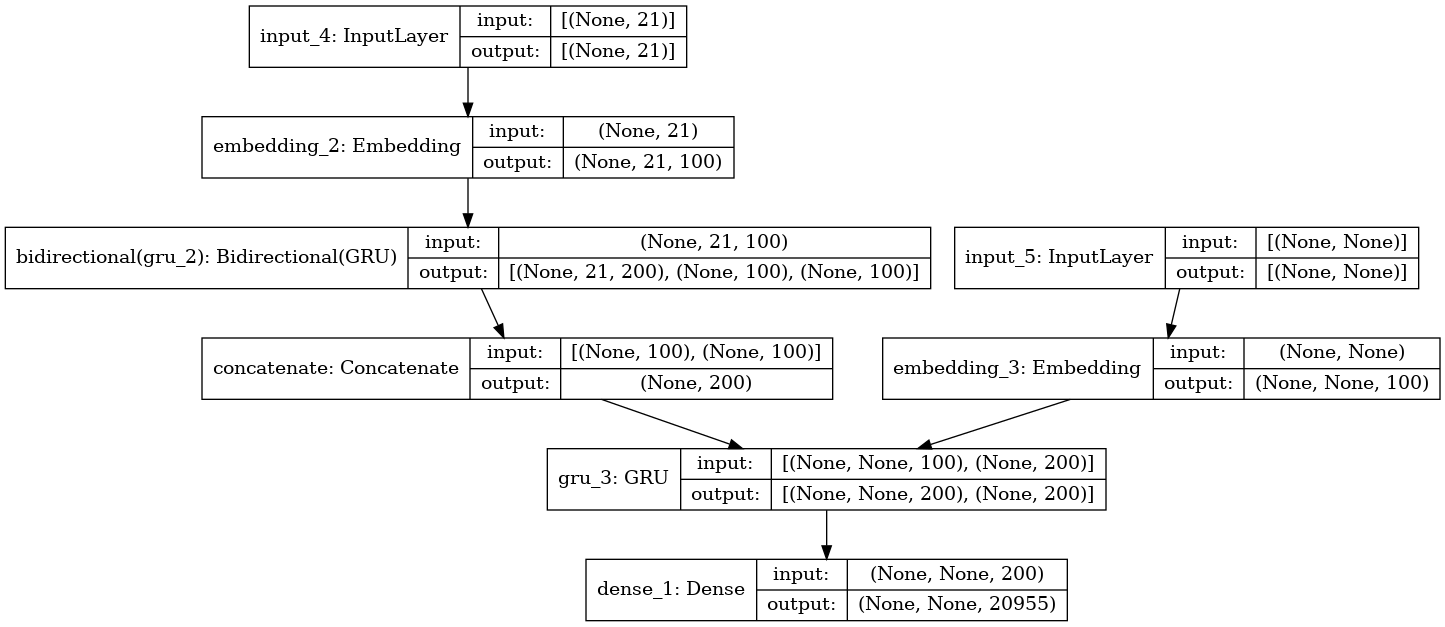

In [63]:
img_file = './Biderectional_GRU_model_arch.png'

tf.keras.utils.plot_model(model2, to_file=img_file, show_shapes=True, show_layer_names=True)

# Fitting the data to model(training)

In [64]:
history2 = model2.fit([X_train_Encoder_input, X_train_Decoder_input], X_train_Decoder_output,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=([X_test_Encoder_input,X_test_Decoder_input],X_test_Decoder_output))

Epoch 1/30
350/350 [==============================] - 44s 115ms/step - loss: 3.2260 - perplexity: 729.5992 - val_loss: 2.5659 - val_perplexity: 13.0398
Epoch 2/30
350/350 [==============================] - 39s 113ms/step - loss: 2.3958 - perplexity: 11.0527 - val_loss: 2.2401 - val_perplexity: 9.4114
Epoch 3/30
350/350 [==============================] - 39s 112ms/step - loss: 2.0850 - perplexity: 8.0816 - val_loss: 1.9655 - val_perplexity: 7.1495
Epoch 4/30
350/350 [==============================] - 39s 112ms/step - loss: 1.8376 - perplexity: 6.2994 - val_loss: 1.7555 - val_perplexity: 5.7936
Epoch 5/30
350/350 [==============================] - 39s 113ms/step - loss: 1.6367 - perplexity: 5.1480 - val_loss: 1.5825 - val_perplexity: 4.8721
Epoch 6/30
350/350 [==============================] - 39s 112ms/step - loss: 1.4622 - perplexity: 4.3234 - val_loss: 1.4339 - val_perplexity: 4.1987
Epoch 7/30
350/350 [==============================] - 39s 113ms/step - loss: 1.3120 - perplexity: 3.71

In [65]:
from keras.models import save_model
model2.save_weights('Bidirectional_Gru_Model.hdf5')

In [66]:
#Load weights
model2.load_weights('./Bidirectional_Gru_Model.hdf5')

# Evaluating the model on test data

In [67]:
perplexity_scores = model2.evaluate([X_test_Encoder_input, X_test_Decoder_input], X_test_Decoder_output)
print("perplexity of Forward only GRU Based encoder decoder model is: {}".format(perplexity_scores))

989/989 [==============================] - 8s 8ms/step - loss: 0.5980 - perplexity: 1.8277
perplexity of Forward only GRU Based encoder decoder model is: [0.5979795455932617, 1.8276746273040771]


# Plotting the graph for train and test loss and perplexity values

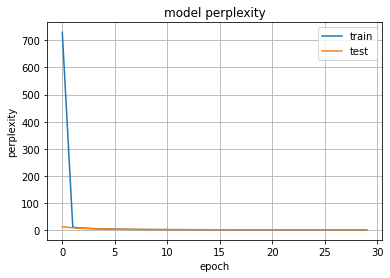

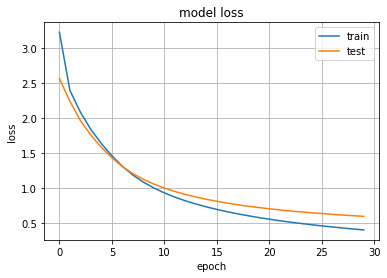

In [68]:
import matplotlib.pyplot as plt
# perplexity for Simple forward only GRU Encoder decoder model
plt.plot(history2.history['perplexity'])
plt.plot(history2.history['val_perplexity'])
plt.title('model perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid()
plt.show()
# Loss for Simple forward only GRU Encoder decoder model
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid()
plt.show()

# Creating the inference for model-2 for final prediction

In [69]:
 # Inference Encoder
encoder_model2 = keras.models.Model(encoder_in_layer, state_h)

 # Inference Decoder
state_input_h = keras.layers.Input(shape=(latent_dim*2,))
decoder_out, decoder_h = decoder_gru(decoder_embedding(decoder_in_layer), initial_state=state_input_h)
decoder_out = decoder_dense(decoder_out)
decoder_model2 = keras.models.Model(inputs=[decoder_in_layer, state_input_h], 
                  outputs=[decoder_out, decoder_h])

# Encoder model inference

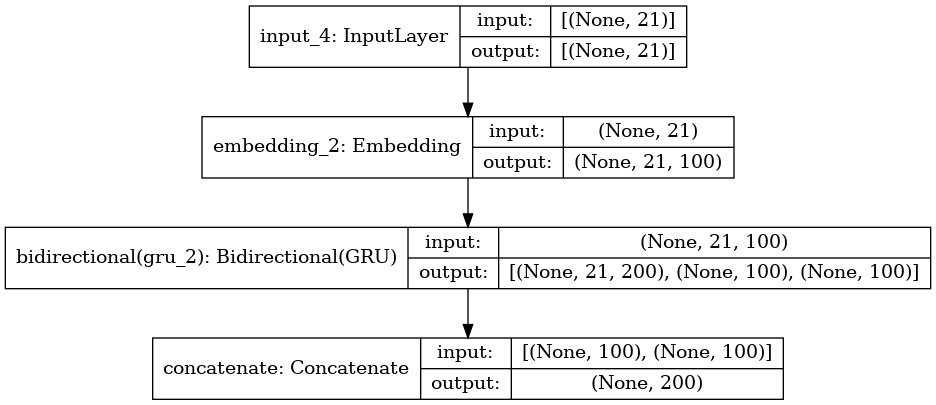

In [70]:
img_file = './Encoder_inference_GRU_model_arch.png'

tf.keras.utils.plot_model(encoder_model2, to_file=img_file, show_shapes=True, show_layer_names=True)

# Decoder model inference

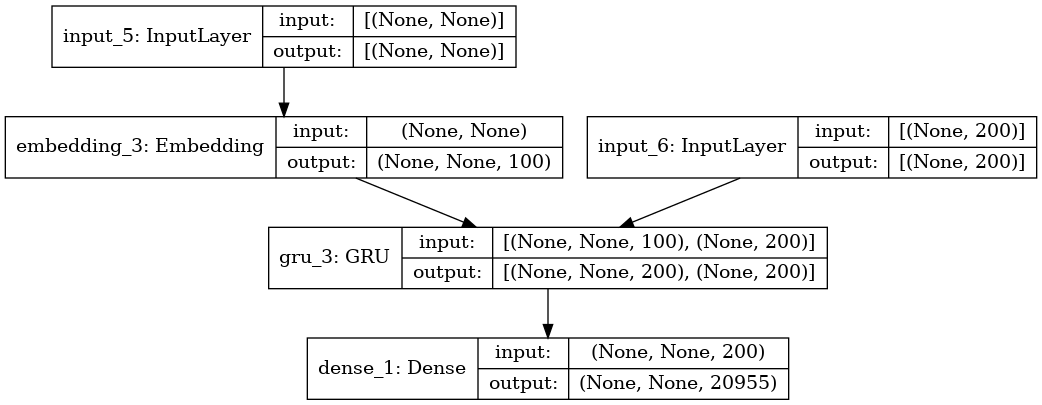

In [71]:
img_file = './Encoder_inference_GRU_model_arch.png'

tf.keras.utils.plot_model(decoder_model2, to_file=img_file, show_shapes=True, show_layer_names=True)

# Final pipeline for prediction

In [72]:
def decode_sequence2(input_seq):
    '''this function will predict the next words sequences given the input sequences'''
    if input_seq.split(' ')[0] != '<start>' and input_seq.split(' ')[-1] != '<end>':
        input_seq = '<start>'+ ' ' + input_seq + ' ' + '<end>'
    
    #print("input seq",input_seq)
    input_seq = Enc_Tokenizer.texts_to_sequences([str(input_seq)])
    input_seq = pad_sequences(input_seq, padding="post",maxlen= 21)
    
     # Encode the input as state vectors.
    state = encoder_model2.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = Dec_Tokenizer.word_index['<start>']
    
    # Encode the input as state vectors.
    curr_word = "<start>"
    decoded_sentence = ''

    i = 0
    while curr_word != "<end>" and i < (20 - 1):
        output_tokens, h = decoder_model2.predict([target_seq, state])

        curr_token = np.argmax(output_tokens[0, 0])

        if (curr_token == 0):
            break;

        curr_word = reverse_target_char_index[curr_token]

        decoded_sentence += ' ' + curr_word
        target_seq[0, 0] = curr_token
        state = h
        i += 1
    if curr_word != "<end>":
        decoded_sentence += ' ' + '<end>'
    return decoded_sentence

# Prediction on some sample very frequenty typed sequences

In [128]:
texts = [
    'here is',
    'please review',
    'thanks for',
    'let me',
    'Let me know if you',
    'can you get',
    'is it okay',
    'it should',
    'call if there is',
    'gave her a',
    'i will let',
    'may i get a copy of all the',
    'how is our trade',
    'this looks like a',
    'i am fine with the changes',
    'please be sure this'
]
for i in texts:
    print('Input ---->' , i)
    print('Predict ---->', decode_sequence2(i))
    print('=='*30)

Input ----> here is
Predict ---->  the latest version of the presentation. ben <end>
Input ----> please review
Predict ---->  the attached outage report. jerry graves office fax <end>
Input ----> thanks for
Predict ---->  the update. i hope you have had the opportunity. have a great weekend! <end>
Input ----> let me
Predict ---->  know if you have any additonal comments. thanks! jan <end>
Input ----> Let me know if you
Predict ---->  have any additonal comments. thanks! office cell <end>
Input ----> can you get
Predict ---->  me the unarchive shortcut to data? stacey <end>
Input ----> is it okay
Predict ---->  with the saddle again. i'll get crackin' kay <end>
Input ----> it should
Predict ---->  be getting my interpretation of what bbc is owed for the feb nyseg gas. john <end>
Input ----> call if there is
Predict ---->  the call in the office before the houston time. <end>
Input ----> gave her a
Predict ---->  note to folks regarding the survey spreadsheet. i don't have some more than

# Now prediction from our dataset

In [83]:
for i in range(10):
    print('Input ---->' , sample["Encoder_input"].iloc[i])
    print('Output ---->' , sample["Decoder_input"].iloc[i])
    print('Predict ---->', decode_sequence2(sample["Encoder_input"].iloc[i]))
    print('=='*50)

Input ----> <start> twanda, here is more information about the project <end>
Output ----> <start> for baxter. michelle
Predict ---->  curve and he for me. thanks. michelle <end>
Input ----> <start> please work with the group so that i am no longer inundated with erequests for <end>
Output ----> <start> additional mailbox space.
Predict ---->  additional mailbox space. <end>
Input ----> <start> for calendar. <end>
Output ----> <start> i may go straight there in the am.
Predict ---->  i have already seen this. i'll call you tomorrow. <end>
Input ----> <start> attached is the legal risk memo in connection with the ceg ceg rio purchase sale agreement with petrobras. <end>
Output ----> <start> randy
Predict ---->  randy <end>
Input ----> <start> please see the attached <end>
Output ----> <start> bid solicitation which is due thursday, april , by a.m. pt . mobidltr. .doc
Predict ---->  credit worksheet for the referenced counterparty. thanks russell <end>
Input ----> <start> fyi. i'm <end>
O

# Calculating the bleu score for model-2

In [92]:
from nltk.translate.bleu_score import sentence_bleu

final_bleu_score=[]
for i in tqdm(range(1000)):
    actual_result=sample_bleu["Decoder_output"].iloc[i]
    predicted=decode_sequence2(sample_bleu["Encoder_input"].iloc[i])
    final_bleu_score.append(sentence_bleu([actual_result.split()], predicted.split()))
print("final bleu score of bidirectional gru model {}".format(np.mean(final_bleu_score)))

100%|██████████| 1000/1000 [06:06<00:00,  2.73it/s]

final bleu score of bidirectional gru model 0.6600686901397889


# Model-3 Forward only LSTM Encoder Decoder Model

In [93]:
# forward only LSTM Encoder layer
encoder_in_layer = tf.keras.layers.Input(shape=(X_train_Encoder_input.shape[1],))

encoder_embedding = tf.keras.layers.Embedding(input_dim=input_vocab, output_dim=embedding_dim)

encoder_lstm = tf.keras.layers.LSTM(units=latent_dim, return_sequences=True, return_state=True)

# Discard the encoder output and use hidden states (h)
encoder_out, state_h,state_c= encoder_lstm(encoder_embedding(encoder_in_layer))

Final_state_h = [state_c, state_h]

# LTSM Decoder layer
decoder_in_layer = tf.keras.layers.Input(shape=(None,))

decoder_embedding = tf.keras.layers.Embedding(input_dim=output_vocab, output_dim=embedding_dim)

decoder_lstm = tf.keras.layers.LSTM(units=latent_dim, return_sequences=True, return_state=True)

# Discard internal states in training, keep only the output sequence
decoder_lstm_out, _,_ = decoder_lstm(decoder_embedding(decoder_in_layer), initial_state=Final_state_h)

decoder_dense = tf.keras.layers.Dense(output_vocab, activation="softmax")

decoder_out_layer = decoder_dense(decoder_lstm_out)

# Define the model that uses the Encoder and the Decoder
model3 = tf.keras.models.Model([encoder_in_layer, decoder_in_layer], decoder_out_layer)

model3.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=[perplexity])

model3.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 21, 100)      1941900     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 100)    2095500     input_8[0][0]                    
____________________________________________________________________________________________

# Simple Forward only LSTM Model Architecture

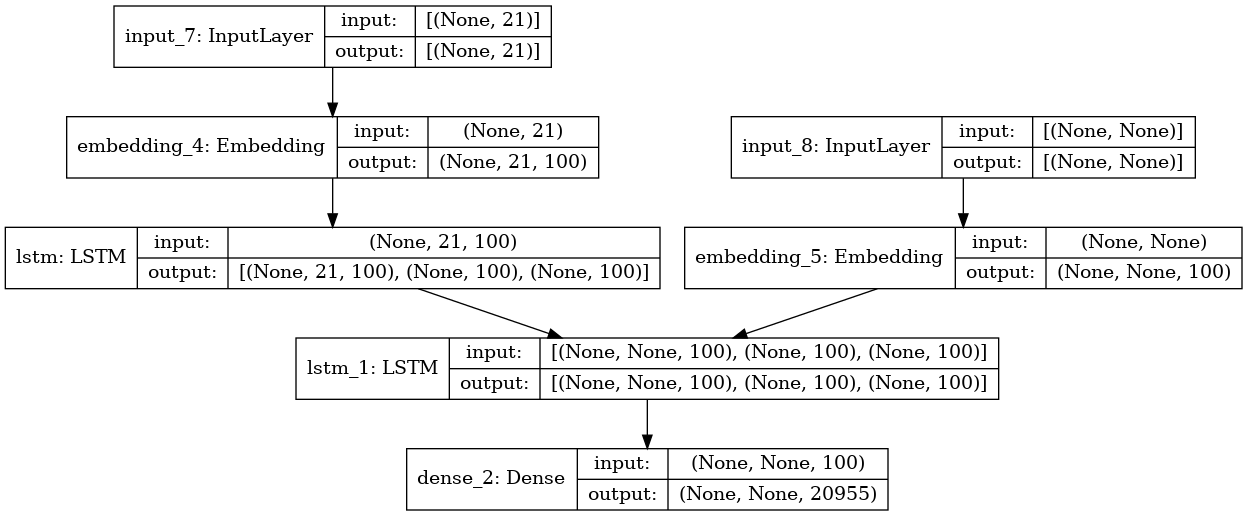

In [94]:
img_file = './Forward_only_LSTM_model_arch.png'

tf.keras.utils.plot_model(model3, to_file=img_file, show_shapes=True, show_layer_names=True)

# Fitting the data to model(training)

In [95]:
history3 = model3.fit([X_train_Encoder_input, X_train_Decoder_input], X_train_Decoder_output,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=([X_test_Encoder_input,X_test_Decoder_input],X_test_Decoder_output))

Epoch 1/30
350/350 [==============================] - 35s 91ms/step - loss: 3.5595 - perplexity: 1005.0875 - val_loss: 2.6609 - val_perplexity: 14.3399
Epoch 2/30
350/350 [==============================] - 31s 89ms/step - loss: 2.5298 - perplexity: 12.6141 - val_loss: 2.4161 - val_perplexity: 11.2234
Epoch 3/30
350/350 [==============================] - 31s 89ms/step - loss: 2.3027 - perplexity: 10.0402 - val_loss: 2.2167 - val_perplexity: 9.1935
Epoch 4/30
350/350 [==============================] - 31s 89ms/step - loss: 2.1279 - perplexity: 8.4190 - val_loss: 2.0659 - val_perplexity: 7.9048
Epoch 5/30
350/350 [==============================] - 31s 89ms/step - loss: 1.9853 - perplexity: 7.2977 - val_loss: 1.9441 - val_perplexity: 6.9972
Epoch 6/30
350/350 [==============================] - 31s 89ms/step - loss: 1.8674 - perplexity: 6.4824 - val_loss: 1.8422 - val_perplexity: 6.3189
Epoch 7/30
350/350 [==============================] - 31s 89ms/step - loss: 1.7648 - perplexity: 5.8496 -

In [96]:
from keras.models import save_model
model3.save_weights('Forward_LSTM_Model.hdf5')

In [97]:
#Load weights
model3.load_weights('./Forward_LSTM_Model.hdf5')

# Evaluating the model on test data

In [98]:
perplexity_scores = model3.evaluate([X_test_Encoder_input, X_test_Decoder_input], X_test_Decoder_output)
print("perplexity of Forward only LSTM Based encoder decoder model is: {}".format(perplexity_scores))

989/989 [==============================] - 7s 7ms/step - loss: 0.9040 - perplexity: 2.4887
perplexity of Forward only LSTM Based encoder decoder model is: [0.9040219187736511, 2.488732099533081]


# Plotting the graph for train and test loss and perplexity values

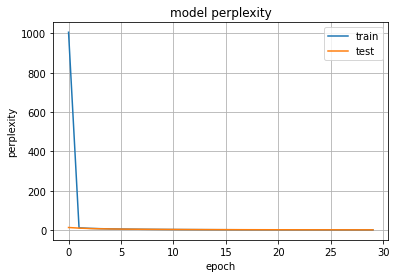

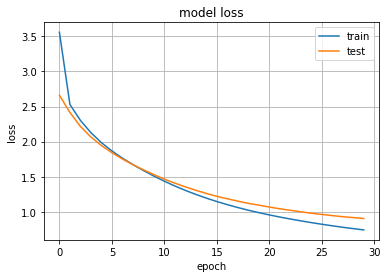

In [99]:
import matplotlib.pyplot as plt
# perplexity for Simple forward only LSTM Encoder decoder model
plt.plot(history3.history['perplexity'])
plt.plot(history3.history['val_perplexity'])
plt.title('model perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid()
plt.show()
# Loss for Simple forward only LSTM Encoder decoder model
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid()
plt.show()

# Creating the inference for model1 for final prediction

In [100]:
 # Inference Encoder
encoder_model3 = keras.models.Model(encoder_in_layer, Final_state_h)

# Inference Decoder
state_input_h = keras.layers.Input(shape=(latent_dim,))
state_input_c = keras.layers.Input(shape=(latent_dim,))
Final_state_input = [state_input_h, state_input_c]
decoder_out, decoder_h,decoder_c = decoder_lstm(decoder_embedding(decoder_in_layer), initial_state=Final_state_input)
decoder_states2 = [decoder_h, decoder_c]
decoder_out = decoder_dense(decoder_out)
decoder_model3 = keras.models.Model(inputs=[decoder_in_layer, Final_state_input], 
                  outputs=[decoder_out,decoder_states2])

# Encoder model inference 

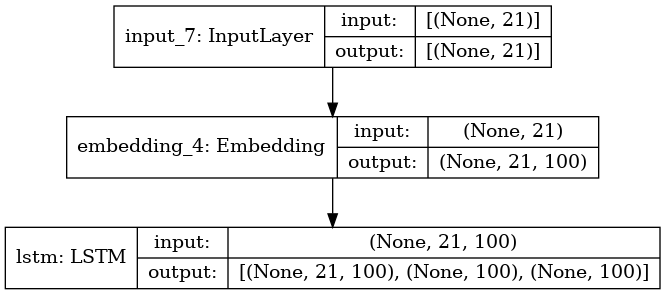

In [101]:
img_file = './Encoder_inference_LSTM_model_arch.png'

tf.keras.utils.plot_model(encoder_model3, to_file=img_file, show_shapes=True, show_layer_names=True)

# Decoder model inference¶

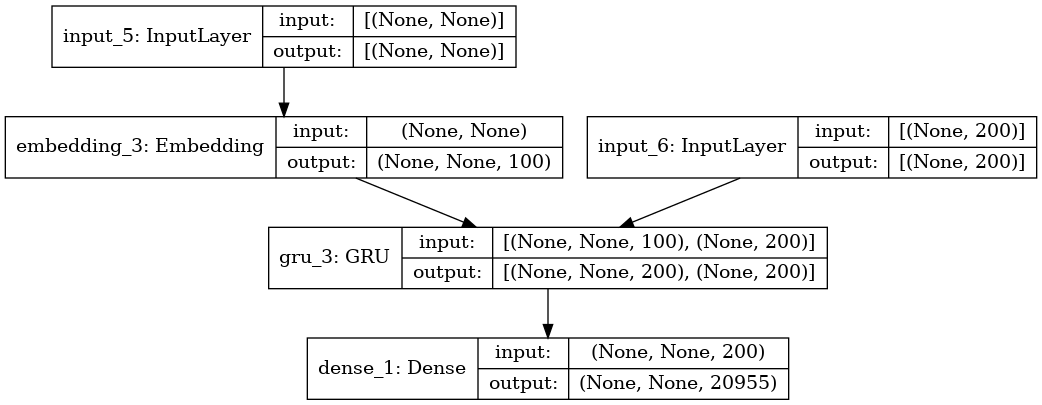

In [102]:
img_file = './Deocder_inference_lstm_model_arch.png'

tf.keras.utils.plot_model(decoder_model2, to_file=img_file, show_shapes=True, show_layer_names=True)

# Final pipeline for prediction

In [103]:
def decode_sequence3(input_seq):
    '''this function will predict the next words sequences given the input sequences'''
    if input_seq.split(' ')[0] != '<start>' and input_seq.split(' ')[-1] != '<end>':
        input_seq = '<start>'+ ' ' + input_seq + ' ' + '<end>'
    
    #print("input seq",input_seq)
    input_seq = Enc_Tokenizer.texts_to_sequences([str(input_seq)])
    input_seq = pad_sequences(input_seq, padding="post",maxlen= 21)
    
     # Encode the input as state vectors.
    state = encoder_model3.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = Dec_Tokenizer.word_index['<start>']
    
    # Encode the input as state vectors.
    curr_word = "<start>"
    decoded_sentence = ''

    i = 0
    while curr_word != "<end>" and i < (20 - 1):
        output_tokens, h = decoder_model3.predict([target_seq, state])

        curr_token = np.argmax(output_tokens[0, 0])

        if (curr_token == 0):
            break;

        curr_word = reverse_target_char_index[curr_token]

        decoded_sentence += ' ' + curr_word
        target_seq[0, 0] = curr_token
        state = h
        i += 1
    if curr_word != "<end>":
        decoded_sentence += ' ' + '<end>'
    return decoded_sentence

# Prediction on some sample very frequenty typed sequences

In [129]:
texts = [
    'here is',
    'please review',
    'thanks for',
    'let me',
    'Let me know if you',
    'can you get',
    'is it okay',
    'it should',
    'call if there is',
    'gave her a',
    'i will let',
    'may i get a copy of all the',
    'how is our trade',
    'this looks like a',
    'i am fine with the changes',
    'please be sure this'
]
for i in texts:
    print('Input ---->' , i)
    print('Predict ---->', decode_sequence3(i))
    print('=='*30)

Input ----> here is
Predict ---->  the latest version of the referenced counterparty dated . call me at . thanks, sonia <end>
Input ----> please review
Predict ---->  the attached memo from the power pool of alberta for . <end>
Input ----> thanks for
Predict ---->  your help on this issue. let me know what you think. kay <end>
Input ----> let me
Predict ---->  know if you have any questions. thanks, fran . . <end>
Input ----> Let me know if you
Predict ---->  have any questions. thanks, fran . . <end>
Input ----> can you get
Predict ---->  a copy of the attached document. thanks, eric gillaspie enron building <end>
Input ----> is it okay
Predict ---->  with you on my calendar this morning. best, jeff <end>
Input ----> it should
Predict ---->  be a great weekend and i am thinking of you ily dq <end>
Input ----> call if there is
Predict ---->  any questions, please call me at . <end>
Input ----> gave her a
Predict ---->  chance to look at this resume. vince <end>
Input ----> i will let
P

# Now prediction from our dataset

In [104]:
for i in range(10):
    print('Input ---->' , sample["Encoder_input"].iloc[i])
    print('Output ---->' , sample["Decoder_input"].iloc[i])
    print('Predict ---->', decode_sequence3(sample["Encoder_input"].iloc[i]))
    print('=='*30)

Input ----> <start> twanda, here is more information about the project <end>
Output ----> <start> for baxter. michelle
Predict ---->  and terms of the attached credit worksheet. thanks brant <end>
Input ----> <start> please work with the group so that i am no longer inundated with erequests for <end>
Output ----> <start> additional mailbox space.
Predict ---->  any of counterparty? <end>
Input ----> <start> for calendar. <end>
Output ----> <start> i may go straight there in the am.
Predict ---->  i think i will be able to make it to you. <end>
Input ----> <start> attached is the legal risk memo in connection with the ceg ceg rio purchase sale agreement with petrobras. <end>
Output ----> <start> randy
Predict ---->  randy <end>
Input ----> <start> please see the attached <end>
Output ----> <start> bid solicitation which is due thursday, april , by a.m. pt . mobidltr. .doc
Predict ---->  file for the referenced counterparty dated . <end>
Input ----> <start> fyi. i'm <end>
Output ----> <s

# Calculating the bleu score for model-3

In [106]:
from nltk.translate.bleu_score import sentence_bleu

final_bleu_score=[]
for i in tqdm(range(1000)):
    actual_result=sample_bleu["Decoder_output"].iloc[i]
    predicted=decode_sequence3(sample_bleu["Encoder_input"].iloc[i])
    final_bleu_score.append(sentence_bleu([actual_result.split()], predicted.split()))
print("final bleu score of forward only LSTM model {}".format(np.mean(final_bleu_score)))

100%|██████████| 1000/1000 [06:36<00:00,  2.52it/s]

final bleu score of forward only LSTM model 0.5800788882663028


# Model-4 Bidirectional LSTM Encoder Decoder Model

In [109]:
# Bidirectional LSTM Encoder layer
encoder_in_layer = tf.keras.layers.Input(shape=(X_train_Encoder_input.shape[1],))

encoder_embedding = tf.keras.layers.Embedding(input_dim=input_vocab, output_dim=embedding_dim)

encoder_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=latent_dim, return_sequences=True, return_state=True))

# Discard the encoder output and use hidden states (h) and cell stata(c) both forward and backward
encoder_out,fstate_h,fstate_c, bstate_h,bstate_c= encoder_bi_lstm(encoder_embedding(encoder_in_layer))

state_h = tf.keras.layers.Concatenate()([fstate_h,bstate_h])
state_c = tf.keras.layers.Concatenate()([fstate_c,bstate_c])
Final_encoder_states = [state_h, state_c]


# LTSM Decoder layer
decoder_in_layer = tf.keras.layers.Input(shape=(None,))

decoder_embedding = tf.keras.layers.Embedding(input_dim=output_vocab, output_dim=embedding_dim)

decoder_lstm = tf.keras.layers.LSTM(units=latent_dim*2, return_sequences=True, return_state=True)

# Discard internal states in training, keep only the output sequence
decoder_gru_out, _,_ = decoder_lstm(decoder_embedding(decoder_in_layer), initial_state=Final_encoder_states)

decoder_dense = tf.keras.layers.Dense(output_vocab, activation="softmax")

decoder_out_layer = decoder_dense(decoder_gru_out)

# Define the model that uses the Encoder and the Decoder
model4 = tf.keras.models.Model([encoder_in_layer, decoder_in_layer], decoder_out_layer)

model4.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=[perplexity])

model4.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 21)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 21, 100)      1941900     input_13[0][0]                   
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 21, 200), (N 160800      embedding_8[0][0]                
___________________________________________________________________________________________

# Bidirectional LSTM Model Architecture

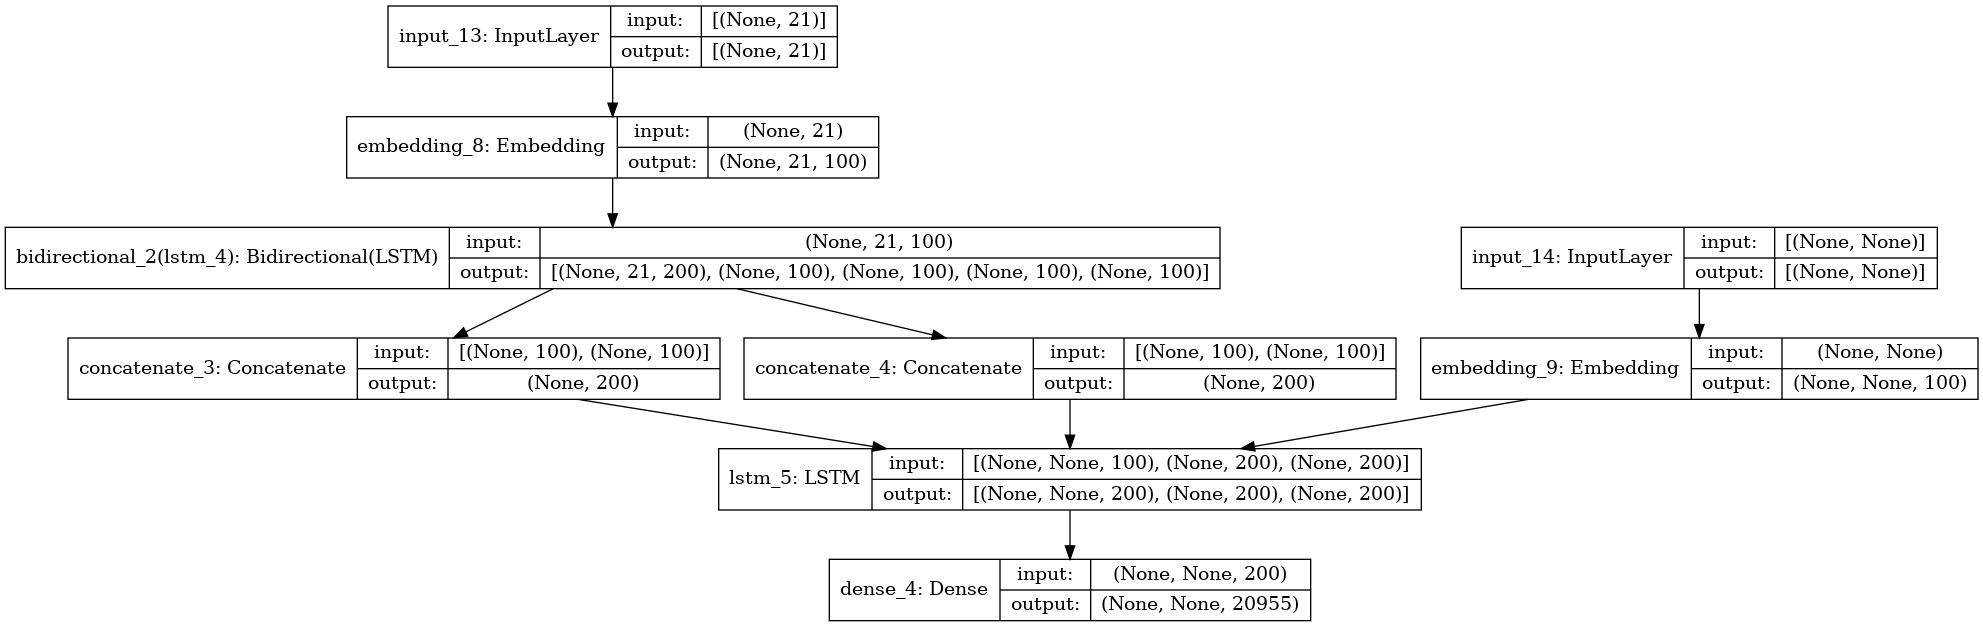

In [110]:
img_file = './Bidirectional_LSTM_model_arch.png'

tf.keras.utils.plot_model(model4, to_file=img_file, show_shapes=True, show_layer_names=True)

# Fitting the data to model(training)

In [111]:
history4 = model4.fit([X_train_Encoder_input, X_train_Decoder_input], X_train_Decoder_output,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=([X_test_Encoder_input,X_test_Decoder_input],X_test_Decoder_output))

Epoch 1/30
350/350 [==============================] - 44s 117ms/step - loss: 3.1891 - perplexity: 636.8430 - val_loss: 2.5608 - val_perplexity: 12.9721
Epoch 2/30
350/350 [==============================] - 40s 114ms/step - loss: 2.4104 - perplexity: 11.1970 - val_loss: 2.2836 - val_perplexity: 9.8298
Epoch 3/30
350/350 [==============================] - 40s 114ms/step - loss: 2.1550 - perplexity: 8.6586 - val_loss: 2.0537 - val_perplexity: 7.8099
Epoch 4/30
350/350 [==============================] - 40s 114ms/step - loss: 1.9445 - perplexity: 7.0094 - val_loss: 1.8748 - val_perplexity: 6.5288
Epoch 5/30
350/350 [==============================] - 40s 114ms/step - loss: 1.7720 - perplexity: 5.8966 - val_loss: 1.7246 - val_perplexity: 5.6174
Epoch 6/30
350/350 [==============================] - 40s 114ms/step - loss: 1.6235 - perplexity: 5.0785 - val_loss: 1.5972 - val_perplexity: 4.9445
Epoch 7/30
350/350 [==============================] - 40s 114ms/step - loss: 1.4931 - perplexity: 4.45

In [112]:
from keras.models import save_model
model4.save_weights('BI_LSTM_Model.hdf5')

In [113]:
#Load weights
model4.load_weights('./BI_LSTM_Model.hdf5')

# Evaluating the model on test data

In [114]:
perplexity_scores = model4.evaluate([X_test_Encoder_input, X_test_Decoder_input], X_test_Decoder_output)
print("perplexity of Forward only LSTM Based encoder decoder model is: {}".format(perplexity_scores))

989/989 [==============================] - 8s 8ms/step - loss: 0.6039 - perplexity: 1.8388
perplexity of Forward only LSTM Based encoder decoder model is: [0.6039369702339172, 1.8388128280639648]


# Plotting the graph for train and test loss and perplexity values

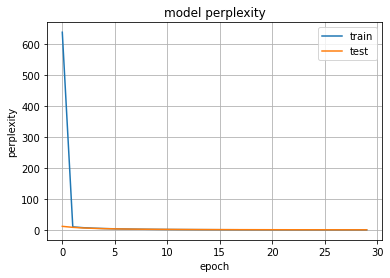

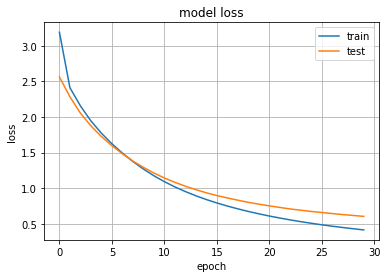

In [115]:
import matplotlib.pyplot as plt
# perplexity for bidirectional LSTM Encoder decoder model
plt.plot(history4.history['perplexity'])
plt.plot(history4.history['val_perplexity'])
plt.title('model perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid()
plt.show()
# Loss for bidirectional LSTM Encoder decoder model
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid()
plt.show()

# Creating the inference for model1 for final prediction

In [116]:
# Inference Decoder
encoder_model4 = tf.keras.models.Model(encoder_in_layer, Final_encoder_states)

state_input_h = tf.keras.layers.Input(shape=(latent_dim*2,))
state_input_c = tf.keras.layers.Input(shape=(latent_dim*2,))
state_input = [state_input_h, state_input_c]
decoder_out, decoder_h,decoder_c = decoder_lstm(decoder_embedding(decoder_in_layer), initial_state=state_input)
decoder_states2 = [decoder_h, decoder_c]
decoder_out = decoder_dense(decoder_out)
decoder_model4 = tf.keras.models.Model(inputs=[decoder_in_layer, state_input], 
                  outputs=[decoder_out,decoder_states2])

# Encoder model inference 

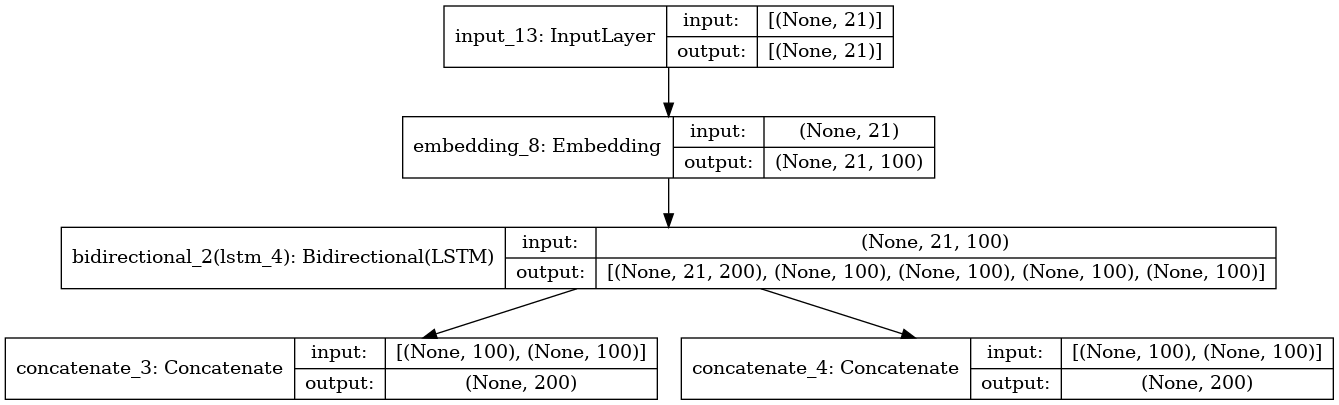

In [117]:
img_file = './Encoder_inference_LSTM_model_arch.png'

tf.keras.utils.plot_model(encoder_model4, to_file=img_file, show_shapes=True, show_layer_names=True)

# Decoder model inference

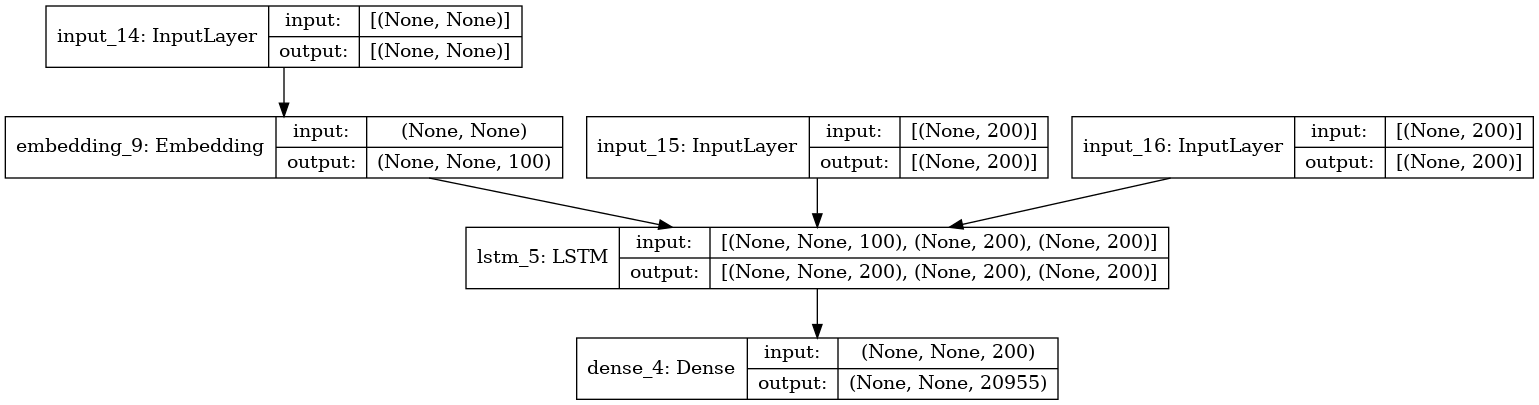

In [118]:
img_file = './Decoder_inference_LSTM_model_arch.png'

tf.keras.utils.plot_model(decoder_model4, to_file=img_file, show_shapes=True, show_layer_names=True)

# Final pipeline for prediction

In [119]:
def decode_sequence4(input_seq):
    '''this function will predict the next words sequences given the input sequences'''
    if input_seq.split(' ')[0] != '<start>' and input_seq.split(' ')[-1] != '<end>':
        input_seq = '<start>'+ ' ' + input_seq + ' ' + '<end>'
    
    #print("input seq",input_seq)
    input_seq = Enc_Tokenizer.texts_to_sequences([str(input_seq)])
    input_seq = pad_sequences(input_seq, padding="post",maxlen= 21)
    
     # Encode the input as state vectors.
    state = encoder_model4.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = Dec_Tokenizer.word_index['<start>']
    
    # Encode the input as state vectors.
    curr_word = "<start>"
    decoded_sentence = ''

    i = 0
    while curr_word != "<end>" and i < (20 - 1):
        output_tokens, h = decoder_model4.predict([target_seq, state])

        curr_token = np.argmax(output_tokens[0, 0])

        if (curr_token == 0):
            break;

        curr_word = reverse_target_char_index[curr_token]

        decoded_sentence += ' ' + curr_word
        target_seq[0, 0] = curr_token
        state = h
        i += 1
    if curr_word != "<end>":
        decoded_sentence += ' ' + '<end>'
    return decoded_sentence

# Prediction on some sample very frequenty typed sequences

In [131]:
texts = [
    'here is',
    'please review',
    'thanks for',
    'let me',
    'Let me know if you',
    'can you get',
    'is it okay',
    'it should',
    'call if there is',
    'gave her a',
    'i will let',
    'may i get a copy of all the',
    'how is our trade',
    'this looks like a',
    'please be sure this'
]
for i in texts:
    print('Input ---->' , i)
    print('Predict ---->', decode_sequence4(i))
    print('=='*30)

Input ----> here is
Predict ---->  the latest draft of the letter agreement for the payment and we can be circulating. carol <end>
Input ----> please review
Predict ---->  the attached memo from sally. we will be attending in the morning. <end>
Input ----> thanks for
Predict ---->  the update. there are the one dancing like a maniac. <end>
Input ----> let me
Predict ---->  know if you have any questions. thanks, fran . . <end>
Input ----> Let me know if you
Predict ---->  have any questions. thanks, fran . . <end>
Input ----> can you get
Predict ---->  a copy of the letter to mog. phillip <end>
Input ----> is it okay
Predict ---->  to you for looking for a meeting with ubs from you. thanks jackie <end>
Input ----> it should
Predict ---->  be in the loop. <end>
Input ----> call if there is
Predict ---->  any questions regarding my asst. tamara black <end>
Input ----> gave her a
Predict ---->  new system to get the same time you were in early ? <end>
Input ----> i will let
Predict ----> 

# Now prediction from our dataset

In [120]:
 for i in range(10):
    print('Input ---->' , sample["Encoder_input"].iloc[i])
    print('Output ---->' , sample["Decoder_input"].iloc[i])
    print('Predict ---->', decode_sequence4(sample["Encoder_input"].iloc[i]))
    print('=='*30)

Input ----> <start> twanda, here is more information about the project <end>
Output ----> <start> for baxter. michelle
Predict ---->  for baxter. michelle <end>
Input ----> <start> please work with the group so that i am no longer inundated with erequests for <end>
Output ----> <start> additional mailbox space.
Predict ---->  additional mailbox space. <end>
Input ----> <start> for calendar. <end>
Output ----> <start> i may go straight there in the am.
Predict ---->  i will try to go home in my alarm to wake me <end>
Input ----> <start> attached is the legal risk memo in connection with the ceg ceg rio purchase sale agreement with petrobras. <end>
Output ----> <start> randy
Predict ---->  randy <end>
Input ----> <start> please see the attached <end>
Output ----> <start> bid solicitation which is due thursday, april , by a.m. pt . mobidltr. .doc
Predict ---->  file for the weekly report th november for your information. thank you. <end>
Input ----> <start> fyi. i'm <end>
Output ----> <st

# Calculating the bleu score for model-4

In [121]:
from nltk.translate.bleu_score import sentence_bleu

final_bleu_score=[]
for i in tqdm(range(1000)):
    actual_result=sample_bleu["Decoder_output"].iloc[i]
    predicted=decode_sequence(sample_bleu["Encoder_input"].iloc[i])
    final_bleu_score.append(sentence_bleu([actual_result.split()], predicted.split()))
print("final bleu score of  bidirectional LSTM model {}".format(np.mean(final_bleu_score)))

100%|██████████| 1000/1000 [06:23<00:00,  2.60it/s]

final bleu score of  bidirectional LSTM model 0.5888253520577289


# Summary of above trained models

In [123]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable = PrettyTable([ "Model","perplexity score", "Bleu Score"])
  
# Add rows
myTable.add_row(["Forward only GRU","2.09", "0.59"])
myTable.add_row(["Bidirectional GRU","1.81", "0.66"])
myTable.add_row(["Forward only LSTM","2.47", "0.58"])
myTable.add_row(["Bidirectional LSTM","1.83", "0.59"])
               
print(myTable)

+--------------------+------------------+------------+
|       Model        | perplexity score | Bleu Score |
+--------------------+------------------+------------+
|  Forward only GRU  |       2.09       |    0.59    |
| Bidirectional GRU  |       1.81       |    0.66    |
| Forward only LSTM  |       2.47       |    0.58    |
| Bidirectional LSTM |       1.83       |    0.59    |
+--------------------+------------------+------------+


# Observations

1. From above table we can clearly see that bidirectional GRU is performing the best out of all 4 models.
2. In Bidirectional GRU we are getting perplexity if 1.81 and bleu score of 0.66 .